# Script for the Ch.2 of larval connectivity across the north central pacific with Constant Depth
Authors: Taylor Ely and Johanna Wren  
Script heavily based on code written by Gabi Mukai, Johanna Wren, and Don Kobayashi

Started Working on this Date: November 19, 2025  

This code is only for Acanthurus nigrofuscus, Chaetodon lunula, Heterocentrotus mamillatus, and Echinometra mathaei because these species have constant depth layers. Use other file for other 2 species


In [12]:
# Load libraries
import numpy as np
import numpy.ma as ma
import netCDF4
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
from scipy import interpolate
import math 
from pathlib import Path

from parcels import FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4, DiffusionUniformKh, Variable, Field, GeographicPolar, Geographic
from datetime import timedelta as timedelta
import datetime
from parcels.tools.converters import TimeConverter
import glob
from datetime import datetime
import datetime

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy
from os.path import isfile
import pytz
from os import path

## Define custom kenels
This is where we define other useful custom kenels.

### Create a fieldset
We are creating a fieldset from HYCOM current files downloaded and stored on a drive. The fieldset is what OceanParcels uses to store all the information it needs for the flowfield that it moves particles through.

The HYCOM data was downloaded using the `HYCOMdownload_ForTaylor.ipynb` script by Johanna Wren and grabs u and v currents for a region 100E-110W and 0-45N for depths 2m,6m,20m,60m,250m. The files are saved as HYCOM_yearmonthdayhour.nc. The HYCOM data can be found on the https://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_e9ba_92b1_0bcd. 

I should probably subset only the depth I need for each species but not sure how to do that

In [14]:
# Build fieldset
fname = sorted(glob.glob("/Volumes/LAPS/redo_HYCOM/HYCOM_199[34]*")) # get all the file names for 2 years

# I need the first time of the first file because I fucked up the release times in my species files
with Dataset(fname[0]) as nc:
    nc_t0 = nc.variables['time'][0]

print("First NC time (seconds since 1970):", nc_t0)

# Continue building fieldset
filenames = {'U': fname, 'V': fname, }
variables = {'U': 'water_u', 'V': 'water_v'}
dimensions = {}
dimensions['U'] = {'lat': 'latitude', 'lon': 'longitude', 'depth': 'LEV', 'time': 'time'}
dimensions['V'] = {'lat': 'latitude', 'lon': 'longitude', 'depth': 'LEV', 'time': 'time'}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, interp_method={'U': 'freeslip', 'V': 'freeslip', 'settle': 'nearest'})

First NC time (seconds since 1970): 725846400.0


### Add diffusivity for randomness using 10 m^2/s

In [15]:
# Set the eddy diffusivity
kh = 10.0   # This is the eddy diffusivity in m2/s
fieldset.add_constant_field('Kh_zonal', kh, mesh='spherical')
#zonal follows lat
fieldset.add_constant_field('Kh_meridional', kh, mesh='spherical') 

### DELETE PARTICLES
`DeleteParticles` allows for particles to be deleted when they exit the dispersal domain. This is applied to the borders of the domain but NOT to land. 

*NOTE: When currents are loaded into the fieldset the missing values over land get converted to zeros so particles that hit land just stop there and bunch up. This shouldn't be a problem for this application, but if it is, we can add land avoidance kernels.*  

In [16]:
# Delete Error
def DeleteErrorParticle(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

# Delete Kernel
def DeleteParticle(particle, fieldset, time):
    print('deleted particle')
    particle.delete()


### AGEING
The `Ageing` kernel removes particles after a specific time period (PLD) by calling the `DeleteParticles` kernel. This allows you to run simulation for long periods of time while removing particles after a set number of days. We read in the PLD as a constant in the fieldset and this kernel grabs the PLD value from there. 

In [17]:
def Ageing(particle, fieldset, time):
    particle.age += particle.dt
    if particle.age >= fieldset.pld:
        particle.delete()

### Add PLD
Here we add the PLD as a constant to te fieldset. <span style="color:red">**Don't forget to change the PLD for each species.**</span> For the model we only care about the max PLD and can select for the min-max in analysis after running model.  
Acanthurus nigrofuscus = 80 days (50-80)  
Chaetodon lunula = 57 days (20-57)   
Heterocentrotus mamillatus = 64 days (38-64)  
Echinometra mathaei = 176 days (24-176)  

In [18]:
# Add PLD to fieldset
pld = 80  # in days
fieldset.add_constant('pld', (pld*86400))

### Define your particle type
We are using a JIT particle but we are adding the age variable along with a release site variable. These variables will print to the output file, but it's easy to change to not show in the ouput file. 

The release site is just a number for the island the particle was released from and makes it much easier when we construct connectivity matrices in post processing. The island values are listed in a separate column in your LAPS_release_sites.csv file. 

Since we are calculating distance traveled we need to add a few more vaiables to our particle. We need the distance calculation from the `Distance` kernel above, as well as the previous lon and lat (that we added in the `AdvectionRK4` above). We are not writing the previous lon and lat in the output file so but we do want the distance written to the file. 

In [19]:
class AgeingParticle(JITParticle):
    age = Variable('age', dtype=np.float32, initial=0.)
    releaseSite = Variable('releaseSite', dtype=np.int32)

### Set particle release locations
Next, we instantiate a `ParticeSet` composed of `JITParticle`. 

`ParticleSet` holds release locations, the number of particles released, the release depth, and how often a particel should be released (daily, every 6h, etc.)  

Particles are released from locations and times specified in a file. We use this if we want to release at for example all reef locations in the islands, or any other list of locations. If we are releaseing multiple particles for each site we need to repeat them with the dates and depths and that is what we are doing with the `np.repeat` part. 

You can add or omit `pdepth`, `time` and `repeatdt` for a one time release at the default `fieldset` depth (in a multi depth file default is top layer) and time. 



<span style="color:red">**Don't forget to change depth based on species.**</span> Here is the list for all species  
Acanthurus nigrofuscus = 60m  
Chaetodon lunula = 20m  
Heterocentrotus mamillatus = 20m  
Echinometra mathaei = 2m  

In [20]:
# Set input file
infile = pd.read_csv('/Users/taylorely/Documents/GradStuff/Ch.2/Anigrofuscus_mergedgloss_1993.csv')

# Convert longitudes from -180:180 to 0:360
infile['lon'] = infile['lon'] % 360

# Set number of particles you want to release
npart = infile.numberparticles

# Set the release depth 
depth = 60

# Fix release time. My release files are in seconds since 1970 in UTC but the fieldset is seconds from the first time of the nc files
habitime2 = infile.release_time.values - nc_t0

# Make vectors that repeat the release site and dept npart number of times
habilon = np.repeat(infile.lon, npart)
habilat = np.repeat(infile.lat, npart)
habisite = np.repeat(infile.site_id, npart)
habidepth = np.repeat(depth, len(habilon))
habitime = np.repeat(habitime2, npart)

# Define the pset
pset = ParticleSet.from_list(fieldset=fieldset, 
                             pclass=AgeingParticle, 
                             lon=habilon,
                             lat=habilat,
                             depth=habidepth,
                             releaseSite=habisite,
                             time=habitime)

In [21]:
#Check to make sure the times look correct for the fieldset and the release times
print("Fieldset time range:",
      fieldset.U.grid.time_full.min(),
      fieldset.U.grid.time_full.max())

print("Release time range:",
      habitime.min(),
      habitime.max())

Fieldset time range: 0.0 63061200.0
Release time range: 26289000.0 31473000.0


### Advect particles

To invoke the custom kernels we wrote earlier we need to combine them into a format Parcels can use. Simply string all the kernels together that you want to use.

In [22]:
# Combine kernels you are using
kernels = pset.Kernel(AdvectionRK4) + pset.Kernel(DiffusionUniformKh) + pset.Kernel(Ageing) + pset.Kernel(DeleteErrorParticle)

Execute the advection. Depending on how many particles you release and the length of your release this may take some time.  

Particles specified in ParticleSet are advected using kernels at a model_dt time step and printed in a netcdf file (outfile) at save_dt time steps. Particels reaching the limits of the domain are removed through recovery.  

We are executing pset.execute here twice: the first time we are releaseing particles daily (or whatever interval we decided to use). To stop this, we then set pset.repeatdt = None followed by a new pset.execute that lasts for as long as the PLD. This way, each particle released will run to the end of the pld. That is, the releases will stop PLD days before the end of the run. So you shouldn't have any trajectories with NA's at the end.  

In [23]:
# Time step in model
model_dt = timedelta(hours=1)

# Time step to save to file
save_dt = timedelta(days=1) # should this be 3hrs since the HYCOM files are every 3 hrs????

# Length of model run
first_release = habitime.min()
last_release  = habitime.max()
run_time = timedelta(seconds=(last_release - first_release) + pld * 86400)


# Set output file name
output_file = pset.ParticleFile(name="/Volumes/LAPS/output_model/Acanthurusnigrofuscus/Ch2_acanthurus_1993_gloss_pld80_depth60_NovDec_afternoonebbtides.zarr", outputdt=save_dt)

# don't print depth
pset.set_variable_write_status('depth', False)

# Execute and release daily during this timeframe
pset.execute(kernels,
            runtime=run_time,
            dt=model_dt, 
            output_file=output_file)

INFO: Output files are stored in /Volumes/LAPS/output_model/Acanthurusnigrofuscus/Ch2_acanthurus_1993_gloss_pld80_depth60_NovDec_afternoonebbtides.zarr.


/opt/miniconda3/envs/parcels/lib/python3.13/site-packages/parcels/particleset.py:1127: ParticleSetWarning: Some of the particles have a start time difference that is not a multiple of outputdt. This could cause the first output of some of the particles that start later in the simulation to be at a different time than expected.
  _warn_outputdt_release_desync(outputdt, starttime, self.particledata.data["time_nextloop"])


100%|████████████████████████▉| 12094200.0/12096000.0 [51:12<00:00, 3936.24it/s]


41

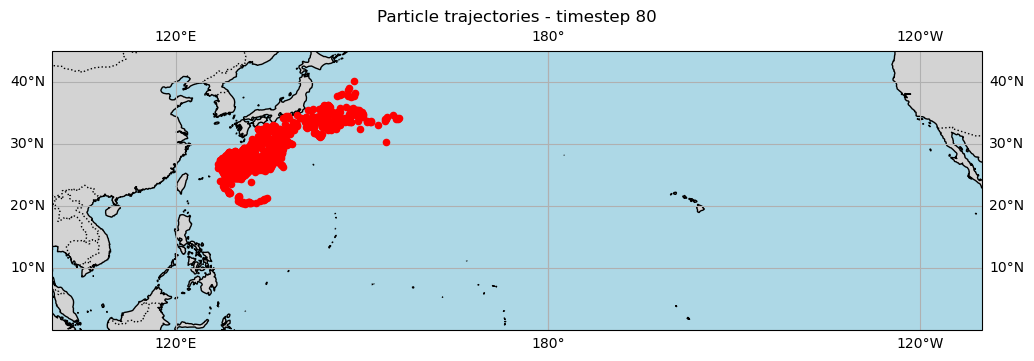

In [25]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# ----------------------------
# Load OceanParcels zarr
# ----------------------------
ds =  xr.open_zarr("/Volumes/LAPS/output_model/Acanthurusnigrofuscus/Ch2_acanthurus_1993_gloss_pld80_depth60_NovDec_afternoonebbtides.zarr", consolidated=False)

n_particles = 10000
particle_subset = ds.isel(trajectory=slice(8000, n_particles))

lons = particle_subset['lon'].values
lats = particle_subset['lat'].values
n_timesteps = lons.shape[1]

# Wrap longitudes 0–360 → -180 to 180 for Cartopy
lons_wrapped = ((lons + 180) % 360) - 180

# Map setup
fig = plt.figure(figsize=(12,6))
# Set central_longitude to 180 to center Pacific nicely
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add features
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray', zorder=0)
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')

# Zoom to 100–250E and 0–45N
lon_min, lon_max = 100, 250
lat_min, lat_max = 0, 45
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.gridlines(draw_labels=True)

# Scatter
scat = ax.scatter([], [], color='red', s=20, transform=ccrs.PlateCarree(), zorder=5)

# Animation
def update(frame):
    scat.set_offsets(np.c_[lons_wrapped[:, frame], lats[:, frame]])
    ax.set_title(f"Particle trajectories - timestep {frame}")
    return scat,

anim = FuncAnimation(fig, update, frames=n_timesteps, interval=200, blit=True)

# Save GIF
anim.save("acanthurus_1993_someparticles.gif", writer=PillowWriter(fps=5))
